<h1 style = "font-size:3rem;color:orange">Pitch Estimation using Autocorrelation</h1>

The pitch, or fundamental period $\tau$ can be estimated using the autocorrelation function, which is based on the similarity between the original and shifted signal:

$r_x = \sum_{n=0}^{N-1}x[n] \cdot x[n+\tau]$

Then the pitch can be obtained by going trough a set of periods and minimizing the objective function. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import librosa                    
import librosa.display            

Function for detection of pitch for segment of data:

In [2]:
def autocor(data, minFreq, maxFreq):    
    nData = len(data);
    minTau = int(max(1,np.ceil(1 / maxFreq)));        # Minimum period
    maxTau = int(min(nData,np.floor(1 / minFreq)));   # Maximum period
    nTau = int(maxTau - minTau);
    
    objectiveFunc = np.zeros(nTau);            # Objective funciton we want to minimize
    
    for tau in range(minTau,maxTau):
        xt = data[range(0,len(data)-1-tau)];                 # Trimeed delayed input signal
        x = data[range(tau,len(data)-1)];                  # Trimmed input data
        
        autoCor = 0;
        
        for n in range(0,len(x)):
            autoCor = autoCor + (1/(nData-tau))*x[n]*xt[n]; # Using the autocorrelation function
        
        objectiveFunc[tau-minTau] = max(autoCor,0);       # Put the outcome into the objective function vec
    
    index = np.argmax(objectiveFunc);
    pitch = 1/(index+minTau);
    
    
    return pitch

Import audio and plot in frequency domain

In [3]:
x , sr = librosa.load('../samples/trumpetFull.wav')

Break into segments and perform autocorrelation

In [40]:
min_freq = 100;                                        # Minimum frequency that can be estimated
max_freq = 1000;                                       # Maximum frequency that can be estimated
 
norm_min_freq = min_freq / sr;                         # Normalized min frequency            
norm_max_freq = max_freq / sr;                         # Normalized max frequency

overlap = 75;                                          # Percentage overlap from previous segment
nData = len(x);                                        # Total amount of samples
segmentLength =  50/1000;                              # Length of each segment in miliseconds
nSegmentLength = segmentLength * sr;                   # Segment Length in samples
iVector = list(range(1, int(nSegmentLength) + 1));     # Vector used for indexing

nShift = int(round((1-overlap/100)*nSegmentLength));        # Segment shift in samples
number_of_segments = int(np.ceil((nData-nSegmentLength+1)/nShift));  # Total amount of segments                                   

pitchVec = np.zeros(nData);                             # Vector containing the estimated pitch using Auto Correlation

for i in range(0,int(number_of_segments)):
    pitchVec[iVector] =  autocor(x[iVector], norm_min_freq, norm_max_freq);              # Estimate pitch using Auto Correlation
    iVector = [z+nShift for z in iVector];
    print(f'Processing section {i+1} of {number_of_segments}');
    

Processing section 1 of 751
Processing section 2 of 751
Processing section 3 of 751
Processing section 4 of 751
Processing section 5 of 751
Processing section 6 of 751
Processing section 7 of 751
Processing section 8 of 751
Processing section 9 of 751
Processing section 10 of 751
Processing section 11 of 751
Processing section 12 of 751
Processing section 13 of 751
Processing section 14 of 751
Processing section 15 of 751
Processing section 16 of 751
Processing section 17 of 751
Processing section 18 of 751
Processing section 19 of 751
Processing section 20 of 751
Processing section 21 of 751
Processing section 22 of 751
Processing section 23 of 751
Processing section 24 of 751
Processing section 25 of 751
Processing section 26 of 751
Processing section 27 of 751
Processing section 28 of 751
Processing section 29 of 751
Processing section 30 of 751
Processing section 31 of 751
Processing section 32 of 751
Processing section 33 of 751
Processing section 34 of 751
Processing section 35 o

Processing section 278 of 751
Processing section 279 of 751
Processing section 280 of 751
Processing section 281 of 751
Processing section 282 of 751
Processing section 283 of 751
Processing section 284 of 751
Processing section 285 of 751
Processing section 286 of 751
Processing section 287 of 751
Processing section 288 of 751
Processing section 289 of 751
Processing section 290 of 751
Processing section 291 of 751
Processing section 292 of 751
Processing section 293 of 751
Processing section 294 of 751
Processing section 295 of 751
Processing section 296 of 751
Processing section 297 of 751
Processing section 298 of 751
Processing section 299 of 751
Processing section 300 of 751
Processing section 301 of 751
Processing section 302 of 751
Processing section 303 of 751
Processing section 304 of 751
Processing section 305 of 751
Processing section 306 of 751
Processing section 307 of 751
Processing section 308 of 751
Processing section 309 of 751
Processing section 310 of 751
Processing

Processing section 552 of 751
Processing section 553 of 751
Processing section 554 of 751
Processing section 555 of 751
Processing section 556 of 751
Processing section 557 of 751
Processing section 558 of 751
Processing section 559 of 751
Processing section 560 of 751
Processing section 561 of 751
Processing section 562 of 751
Processing section 563 of 751
Processing section 564 of 751
Processing section 565 of 751
Processing section 566 of 751
Processing section 567 of 751
Processing section 568 of 751
Processing section 569 of 751
Processing section 570 of 751
Processing section 571 of 751
Processing section 572 of 751
Processing section 573 of 751
Processing section 574 of 751
Processing section 575 of 751
Processing section 576 of 751
Processing section 577 of 751
Processing section 578 of 751
Processing section 579 of 751
Processing section 580 of 751
Processing section 581 of 751
Processing section 582 of 751
Processing section 583 of 751
Processing section 584 of 751
Processing

Plot the estimated pitch and compare to STFT

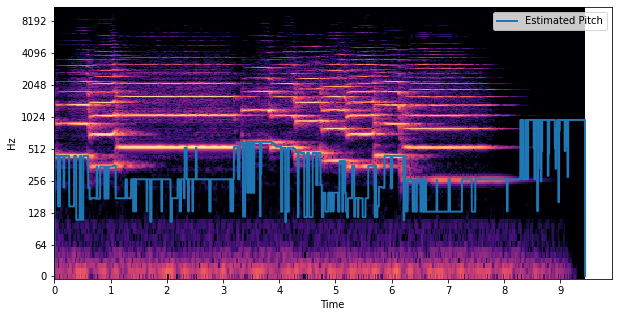

In [44]:
STFT = librosa.stft(x) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
fig, ax = plt.subplots(figsize = (10, 5))
img = librosa.display.specshow(STFT_db,
                               y_axis='log',
                               x_axis='time', 
                               ax=ax)

pitch_norm = pitchVec * sr
timeVec = np.arange(0, nData/sr, 1/sr, dtype=np.float64)

plt.plot(timeVec, pitch_norm, lw=2, label = 'Estimated Pitch')
plt.legend()
plt.show()

(208153,)
208153
